In [1]:
## Import required libraries

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras import Input

2026-02-05 15:28:53.737232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770285533.755581  182980 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770285533.760736  182980 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/home/riya/miniconda3/envs/mlinhep/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
## Toy datasets

def sample_sphere(n_samples, radius=1.0):
    vec = np.random.normal(size=(n_samples, 3))
    vec /= np.linalg.norm(vec, axis=1)[:, None]
    r = radius * np.cbrt(np.random.uniform(0, 1, n_samples))
    vec *= r[:, None]
    return vec

def sample_spheroid(n_samples, a=1.0, b=1.5, c=1.5):
    vec = np.random.normal(size=(n_samples, 3))
    vec /= np.linalg.norm(vec, axis=1)[:, None]
    r = np.cbrt(np.random.uniform(0, 1, n_samples))
    vec *= r[:, None]
    vec[:, 0] *= a
    vec[:, 1] *= b
    vec[:, 2] *= c
    return vec

def sample_cuboid(n_samples, x_len=3.0, y_len=3.0, z_len=3.0):
    x = np.random.uniform(-x_len/2, x_len/2, n_samples)
    y = np.random.uniform(-y_len/2, y_len/2, n_samples)
    z = np.random.uniform(-z_len/2, z_len/2, n_samples)
    return np.stack([x, y, z], axis=1)

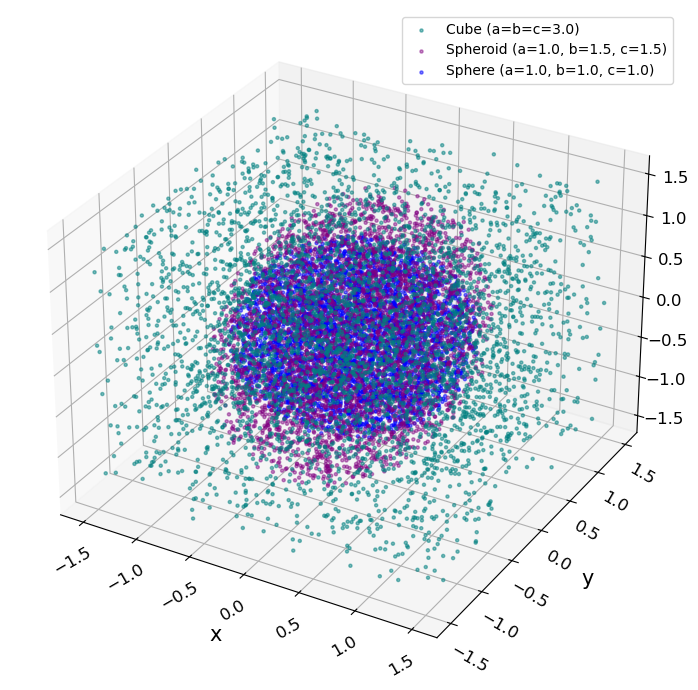

In [3]:
## Visualize datasets

n_train_samples = 4000
n_test_samples  = 4000

X_sphere_train = sample_sphere(n_train_samples)
X_sphere_test  = sample_sphere(n_test_samples)

X_spheroid     = sample_spheroid(n_test_samples)
X_cuboid       = sample_cuboid(n_test_samples)


fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# Cuboid
ax.scatter(X_cuboid[:,0], X_cuboid[:,1], X_cuboid[:,2],
          s=5, alpha=0.5, c="teal", label="Cube (a=b=c=3.0)")
# Spheroid
ax.scatter(X_spheroid[:,0], X_spheroid[:,1], X_spheroid[:,2],
           s=5, alpha=0.45, c="purple", label="Spheroid (a=1.0, b=1.5, c=1.5)")
# Sphere
ax.scatter(X_sphere_test[:,0], X_sphere_test[:,1], X_sphere_test[:,2],
           s=5, alpha=0.5, c="blue", label="Sphere (a=1.0, b=1.0, c=1.0)")

ax.set_xlabel("x", fontsize=15, labelpad=10)
ax.set_ylabel("y", fontsize=15, labelpad=10)
ax.set_zlabel("z", fontsize=15, labelpad=10)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='x', rotation=30)  
ax.tick_params(axis='y', rotation=-30)
ax.legend(fontsize=15, loc='upper right')
ax.grid(True, linestyle='--', alpha=0.1)
ax.legend()
ax.set_title("")
plt.tight_layout()
plt.show()

In [4]:
## Training

X_train, X_val = train_test_split(X_sphere_train, shuffle=True, test_size=0.2)
print("Train shape:", X_train.shape, "Validation shape:", X_val.shape)
n_features = X_train.shape[1]

# Normalize dataset
scaler = StandardScaler() #Standard scaler (another option is min-max scaling)
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train).astype('float32')
X_val_scaled = scaler.transform(X_val).astype('float32')
X_sphere_test_scaled = scaler.transform(X_sphere_test).astype('float32')
X_spheroid_scaled = scaler.transform(X_spheroid).astype('float32')
X_cuboid_scaled = scaler.transform(X_cuboid).astype('float32')

Train shape: (3200, 3) Validation shape: (800, 3)


In [5]:
## VAE model

n_features = 3
latent_dim = 2
beta = 0.1


# Encoder
inputs = layers.Input(shape=(n_features,))
x = layers.Dense(8, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])


# Decoder
x = layers.Dense(8, activation='relu')(z)
outputs = layers.Dense(n_features, activation='linear')(x)

vae = Model(inputs, outputs)


class VAELossLayer(layers.Layer):
    def __init__(self, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.beta = beta

    def call(self, inputs_and_outputs):
        inputs, outputs, z_mean, z_log_sigma = inputs_and_outputs

        # Reconstruction loss
        recon_loss = K.sum(K.square(outputs - inputs), axis=-1)
        recon_loss = K.mean(recon_loss)

        # KL divergence
        kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(2*z_log_sigma), axis=-1)
        kl_loss = K.mean(kl_loss)

        self.add_loss(recon_loss + self.beta * kl_loss)
        return outputs

outputs = VAELossLayer(beta=beta)([inputs, outputs, z_mean, z_log_sigma])
vae = Model(inputs, outputs)

vae.compile(optimizer='adam')
vae.summary()

2026-02-05 15:28:55.466865: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8)         │         32 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │         18 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │         18 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 2)         │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 8)         │         24 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 3)         │         27 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 3)         │          0 │ input_layer[0][0… │
│ (VAELossLayer)      │                   │            │ dense_4[0][0],    │
│                     │                   │            │ dense_1[0][0],    │
│                     │                   │            │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 119 (476.00 B)

 Trainable params: 119 (476.00 B)

 Non-trainable params: 0 (0.00 B)

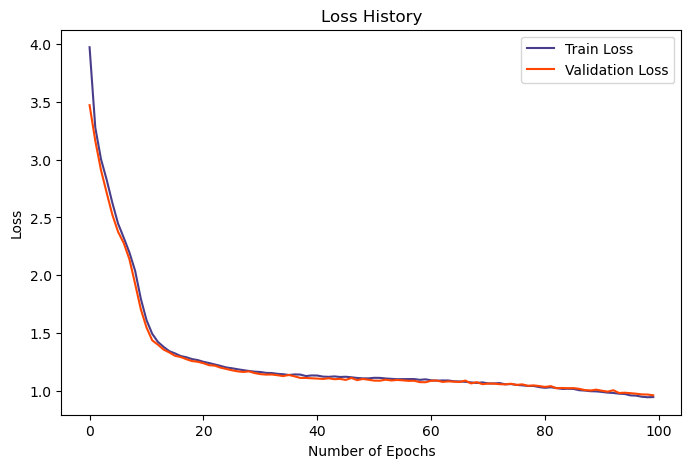

In [6]:
## Training history
history = vae.fit(
    X_train_scaled, X_train_scaled,
    validation_data=(X_val_scaled, X_val_scaled),
    epochs=100,
    batch_size=64,
    verbose=0
)

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss', color='darkslateblue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orangered')
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Loss History")
plt.legend()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


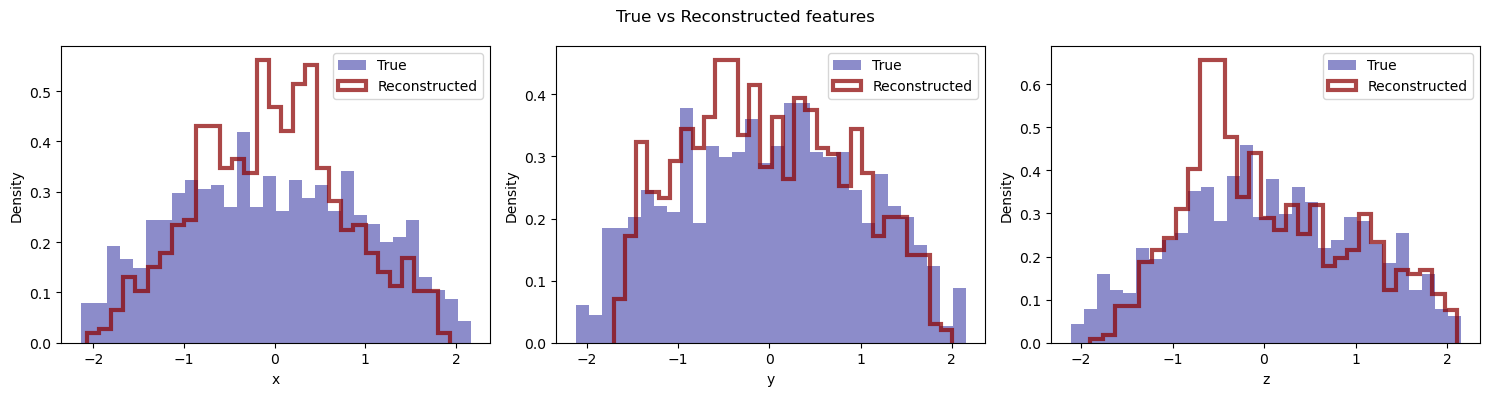

In [7]:
## True vs reconstructed features

def plot_hist_true_vs_reco(model, X_scaled, title="title"):
    X_pred = model.predict(X_scaled)
    n_features = X_scaled.shape[1]
    feature_names = ['x','y','z']
    
    plt.figure(figsize=(15,4))
    
    for i in range(n_features):
        plt.subplot(1, n_features, i+1)
        # True values: step histogram
        plt.hist(X_scaled[:, i], bins=30, alpha=0.45, histtype='stepfilled', color='darkblue', label='True', density=True)
        # Reconstructed values: also as step histogram
        plt.hist(X_pred[:, i], bins=30, alpha=0.72, linewidth=3.0, histtype='step', color='darkred', label='Reconstructed', density=True)
        plt.xlabel(feature_names[i])
        plt.ylabel("Density")
        plt.legend()
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_hist_true_vs_reco(vae, X_val_scaled, title="True vs Reconstructed features")

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step


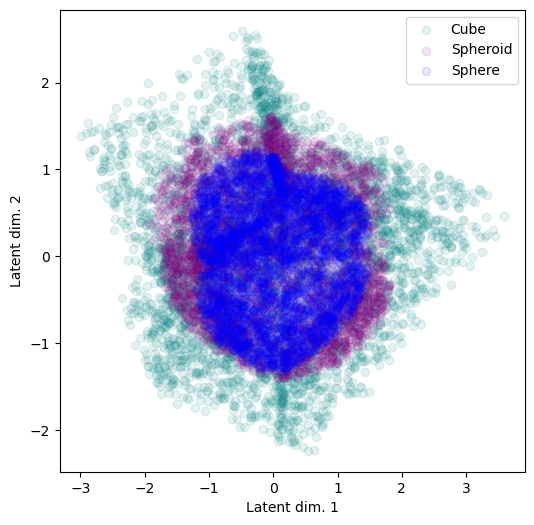

In [8]:
## Latent space visualization

encoder    = Model(inputs, z_mean)
z_sphere   = encoder.predict(X_sphere_test_scaled)
z_spheroid = encoder.predict(X_spheroid_scaled)
z_cuboid   = encoder.predict(X_cuboid_scaled)

# 2D latent scatter
plt.figure(figsize=(6,6))
plt.scatter(z_cuboid[:,0], z_cuboid[:,1], alpha=0.1, label='Cube', color='teal')
plt.scatter(z_spheroid[:,0], z_spheroid[:,1], alpha=0.1, label='Spheroid', color='purple')
plt.scatter(z_sphere[:,0], z_sphere[:,1], alpha=0.1, label='Sphere', color='blue')


plt.xlabel("Latent dim. 1")
plt.ylabel("Latent dim. 2")
plt.legend()
plt.title("")
plt.show()